## Assignment : 14

<pre>
1. Preprocess all the Data we have in DonorsChoose <a href='https://drive.google.com/drive/folders/1MIwK7BQMev8f5CbDDVNLPaFGB32pFN60'>Dataset</a> use train.csv
2. Combine 4 essay's into one column named - 'preprocessed_essays'. 
3. After step 2 you have to train 3 types of models as discussed below. 
4. For all the model use <a href='https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics'>'auc'</a> as a metric. check <a href='https://datascience.stackexchange.com/a/20192'>this</a> for using auc as a metric 
5. You are free to choose any number of layers/hiddden units but you have to use same type of architectures shown below. 
6. You can use any one of the optimizers and choice of Learning rate and momentum, resources: <a href='http://cs231n.github.io/neural-networks-3/'>cs231n class notes</a>, <a href='https://www.youtube.com/watch?v=hd_KFJ5ktUc'>cs231n class video</a>. 
7. For all the model's use <a href='https://www.youtube.com/watch?v=2U6Jl7oqRkM'>TensorBoard</a> and plot the Metric value and Loss with epoch. While submitting, take a screenshot of plots and include those images in .ipynb notebook and PDF. 
8. Use Categorical Cross Entropy as Loss to minimize.
</pre>

### Model-1

Build and Train deep neural network as shown below

<img src='https://i.imgur.com/w395Yk9.png'>
ref: https://i.imgur.com/w395Yk9.png

- __Input_seq_total_text_data__ --- You have to give Total text data columns. After this use the Embedding layer to get word vectors. Use given predefined glove word vectors, don't train any word vectors. After this use LSTM and get the LSTM output and Flatten that output. 
- __Input_school_state__ --- Give 'school_state' column as input to embedding layer and Train the Keras Embedding layer. 
- __Project_grade_category__  --- Give 'project_grade_category' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_categories__ --- Give 'input_clean_categories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_clean_subcategories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_teacher_prefix' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_remaining_teacher_number_of_previously_posted_projects._resource_summary_contains_numerical_digits._price._quantity__ ---concatenate remaining columns and add a Dense layer after that. 



- For LSTM, you can choose your sequence padding methods on your own or you can train your LSTM without padding, there is no restriction on that.

Below is an example of embedding layer for a categorical columns. In below code all are dummy values, we gave only for referance. 

In [ ]:
# https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
# input_layer = Input(shape=(n,))
# embedding = Embedding(no_1, no_2, input_length=n)(input_layer)
# flatten = Flatten()(embedding)

### 1. Go through this blog, if you have any doubt on using predefined Embedding values in Embedding layer - https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
### 2. Please go through this link https://keras.io/getting-started/functional-api-guide/ and check the 'Multi-input and multi-output models' then you will get to know how to give multiple inputs. 

### Model-2

Use the same model as above but for 'input_seq_total_text_data' give only some words in the sentance not all the words. Filter the words as below. 

<pre>
1. Train the TF-IDF on the Train data <br>
2. Get the idf value for each word we have in the train data. <br>
3. Remove the low idf value and high idf value words from our data. Do some analysis on the Idf values and based on those values choose the low and high threshold value. Because very frequent words and very very rare words don't give much information. (you can plot a box plots and take only the idf scores within IQR range and corresponding words)<br>
4. Train the LSTM after removing the Low and High idf value words. (In model-1 Train on total data but in Model-2 train on data after removing some words based on IDF values)
</pre>

### Model-3

<img src='https://i.imgur.com/fkQ8nGo.png'>
ref: https://i.imgur.com/fkQ8nGo.png


- __input_seq_total_text_data__: <br>
<pre>
    . Use text column('essay'), and use the Embedding layer to get word vectors. <br>
    . Use given predefined glove word vectors, don't train any word vectors. <br>
    . Use LSTM that is given above, get the LSTM output and Flatten that output. <br>
    . You are free to preprocess the input text as you needed. <br>
</pre>
- __Other_than_text_data__:<br>
<pre>
    . Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors <br>
    . Neumerical values and use <a href='https://keras.io/getting-started/sequential-model-guide/#sequence-classification-with-1d-convolutions'>CNN1D</a> as shown in above figure. <br>
    . You are free to choose all CNN parameters like kernel sizes, stride.<br>
    
</pre>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Importing libraries

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import tensorflow as tf
import tensorflow.keras.backend as K

from tensorflow.keras import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Conv1D, Concatenate, MaxPool1D, Flatten, Dropout, Dense, BatchNormalization,LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, TerminateOnNaN, Callback
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import Callback

from sklearn.feature_extraction.text import TfidfVectorizer

import pickle
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/preprocessed_data.csv')

In [ ]:
df.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03


In [ ]:
len(df)

109248

In [ ]:
x_tr , y_train , x_te, y_test = train_test_split(df,df['project_is_approved'],test_size=0.20,random_state = 42,stratify=df['project_is_approved'])

In [ ]:
x_tr.shape,x_te.shape

((87398, 9), (87398,))

In [ ]:
x_train,cv_train,x_test,cv_test = train_test_split(x_tr,x_te,test_size=0.25,random_state = 42,stratify=x_te)

In [ ]:
x_train.shape,cv_train.shape

((65548, 9), (21850, 9))

#Custom AUC Score

In [ ]:
# def auc1(y_true, y_pred):
#     if len(tf.unique(y_true[:,1])) == 1:
#         return 0.5
#     else:
#         return roc_auc_score(tf.eval(y_true), tf.eval(y_pred))

def aucroc(y_true,y_pred):
    # print('The values are')
    # print(type(y_true),type(y_pred))
    return tf.py_function(roc_auc_score,(y_true,y_pred),tf.double)

###Collapse

In [ ]:
# def f1(y_true, y_pred):
#     """
#     f1 score

#     :param y_true:
#     :param y_pred:
#     :return:
#     """

#     y_pred = y_pred.numpy()
#     y_true = y_true.numpy()

#     # tp_3d = K.concatenate(
#     #     [
#     #         K.cast(y_true, 'bool'),
#     #         K.cast(K.round(y_pred), 'bool'),
#     #         K.cast(K.ones_like(y_pred), 'bool')
#     #     ], axis=1
#     # )

#     # fp_3d = K.concatenate(
#     #     [
#     #         K.cast(K.abs(y_true - K.ones_like(y_true)), 'bool'),
#     #         K.cast(K.round(y_pred), 'bool'),
#     #         K.cast(K.ones_like(y_pred), 'bool')
#     #     ], axis=1
#     # )

#     # fn_3d = K.concatenate(
#     #     [
#     #         K.cast(y_true, 'bool'),
#     #         K.cast(K.abs(K.round(y_pred) - K.ones_like(y_pred)), 'bool'),
#     #         K.cast(K.ones_like(y_pred), 'bool')
#     #     ], axis=1
#     # )

#     # tp = np.asarray(K.sum(K.cast(K.all(tp_3d, axis=1), 'int32')))
#     # fp = np.asarray(K.sum(K.cast(K.all(fp_3d, axis=1), 'int32')))
#     # fn = np.asarray(K.sum(K.cast(K.all(fn_3d, axis=1), 'int32')))

#     # precision = tp / (tp + fp)
#     # recall = tp / (tp + fn)
#     # return 2 * ((precision * recall) / (precision + recall))
#     return roc_auc_score(y_true,y_pred)

#Embedding essay

In [ ]:
tokenizer = Tokenizer(num_words=10000)

In [ ]:
tokenizer.fit_on_texts(x_train['essay'])

In [ ]:
word_index = tokenizer.word_index

In [ ]:
len(word_index)

46259

In [ ]:
x_test[:5]

47020    1
58489    1
69567    1
42565    1
14058    0
Name: project_is_approved, dtype: int64

In [ ]:
encoded_train = tokenizer.texts_to_sequences(x_train['essay'])


In [ ]:
encoded_cv = tokenizer.texts_to_sequences(cv_train['essay'])
encoded_test = tokenizer.texts_to_sequences(y_train['essay'])

In [ ]:
encoded_train = np.array(encoded_train)
encoded_cv = np.array(encoded_cv)
encoded_test = np.array(encoded_test)

In [ ]:
len(encoded_train[5])

120

In [ ]:
padded_train = pad_sequences(encoded_train, maxlen= 350,padding='post',truncating='post')

In [ ]:
padded_cv = pad_sequences(encoded_cv, maxlen= 350,padding='post',truncating='post')
padded_test = pad_sequences(encoded_test, maxlen= 350,padding='post',truncating='post')


In [ ]:
with open('/content/drive/MyDrive/Datasets/glove_vectors','rb') as g:
    glove = pickle.load(g)
    words_glove = set(glove.keys())

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = glove.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

100%|██████████| 46259/46259 [00:00<00:00, 415124.71it/s]


##Input layer 1 - Essay

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# input_layer_1 = Input(shape = (350, ), name = "Input_Layer_1")

# embed_layer_essay = Embedding(input_dim = len(word_index) + 1, output_dim = 300, weights = [embedding_matrix], 
#                         input_length = 350, trainable = False, 
#                         name = "Embedding_Layer_essay")(input_layer_1)

# lstm_layer = LSTM(32)(embed_layer_essay)

# flatten_1 = Flatten(name='lstm_flatten')(lstm_layer)


#School state

In [ ]:
tokenizer1 = Tokenizer()

In [ ]:
tokenizer1.fit_on_texts(x_train['school_state'])

In [ ]:
state_index = tokenizer1.word_index

In [ ]:
state_index

{'ak': 44,
 'al': 23,
 'ar': 33,
 'az': 19,
 'ca': 1,
 'co': 32,
 'ct': 25,
 'dc': 38,
 'de': 42,
 'fl': 4,
 'ga': 7,
 'hi': 39,
 'ia': 35,
 'id': 34,
 'il': 6,
 'in': 11,
 'ks': 36,
 'ky': 29,
 'la': 14,
 'ma': 15,
 'md': 26,
 'me': 40,
 'mi': 9,
 'mn': 30,
 'mo': 12,
 'ms': 28,
 'mt': 48,
 'nc': 5,
 'nd': 49,
 'ne': 45,
 'nh': 43,
 'nj': 18,
 'nm': 37,
 'nv': 27,
 'ny': 3,
 'oh': 13,
 'ok': 17,
 'or': 31,
 'pa': 10,
 'ri': 46,
 'sc': 8,
 'sd': 47,
 'tn': 22,
 'tx': 2,
 'ut': 24,
 'va': 20,
 'vt': 51,
 'wa': 16,
 'wi': 21,
 'wv': 41,
 'wy': 50}

In [ ]:
encoded_train_state = tokenizer1.texts_to_sequences(x_train['school_state'])

In [ ]:
encoded_cv_state = tokenizer1.texts_to_sequences(cv_train['school_state'])
encoded_test_state = tokenizer1.texts_to_sequences(y_train['school_state'])

In [ ]:
encoded_train_state = np.array(encoded_train_state)
encoded_cv_state = np.array(encoded_cv_state)
encoded_test_state = np.array(encoded_test_state)

In [ ]:
encoded_train_state[:5]

array([[ 2],
       [29],
       [ 6],
       [31],
       [ 5]])

In [ ]:
# input_layer_2 = Input(shape = (1, ), name = "Input_Layer_2")

# embed_layer_state = Embedding(input_dim = len(state_index) + 1, output_dim = 5, 
#                         input_length = 1, trainable = True, 
#                         name = "Embedding_Layer_state")(input_layer_2)

# flatten_2 = Flatten(name='state_flatten')(embed_layer_state)

#Project grade

In [ ]:
tokenizer1 = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')   #excluded _ 

In [ ]:
tokenizer1.fit_on_texts(x_train['project_grade_category'])

In [ ]:
grade_index = tokenizer1.word_index

In [ ]:
grade_index

{'grades_3_5': 2, 'grades_6_8': 3, 'grades_9_12': 4, 'grades_prek_2': 1}

In [ ]:
encoded_train_grade = tokenizer1.texts_to_sequences(x_train['project_grade_category'])

In [ ]:
encoded_cv_grade = tokenizer1.texts_to_sequences(cv_train['project_grade_category'])
encoded_test_grade = tokenizer1.texts_to_sequences(y_train['project_grade_category'])

In [ ]:
encoded_train_grade = np.array(encoded_train_grade)
encoded_cv_grade = np.array(encoded_cv_grade)
encoded_test_grade = np.array(encoded_test_grade)

In [ ]:
encoded_train_grade[:5]

array([[1],
       [1],
       [2],
       [2],
       [2]])

In [ ]:
# input_layer_3 = Input(shape = (1, ), name = "Input_Layer_3")

# embed_layer_grade = Embedding(input_dim = len(grade_index) + 1, output_dim = 5, 
#                         input_length = 1, trainable = True, 
#                         name = "Embedding_Layer_state")(input_layer_3)

# flatten_3 = Flatten(name='grade_flatten')(embed_layer_grade)

#clean_categories

In [ ]:
tokenizer1 = Tokenizer()

In [ ]:
tokenizer1.fit_on_texts(x_train['clean_categories'])

In [ ]:
clean_index = tokenizer1.word_index

In [ ]:
clean_index

{'appliedlearning': 8,
 'arts': 10,
 'care': 14,
 'civics': 12,
 'health': 5,
 'history': 11,
 'hunger': 15,
 'language': 2,
 'literacy': 1,
 'math': 3,
 'music': 9,
 'science': 4,
 'specialneeds': 7,
 'sports': 6,
 'warmth': 13}

In [ ]:
encoded_train_clean = tokenizer1.texts_to_sequences(x_train['clean_categories'])

In [ ]:
encoded_cv_clean = tokenizer1.texts_to_sequences(cv_train['clean_categories'])
encoded_test_clean = tokenizer1.texts_to_sequences(y_train['clean_categories'])

In [ ]:
encoded_train_clean = np.array(encoded_train_clean)
encoded_cv_clean = np.array(encoded_cv_clean)
encoded_test_clean = np.array(encoded_test_clean)

In [ ]:
encoded_train_clean[:10]

array([list([1, 2]), list([1, 2, 3, 4]), list([3, 4]),
       list([1, 2, 9, 10]), list([1, 2]), list([1, 2]), list([5, 6]),
       list([5, 6]), list([3, 4]), list([1, 2])], dtype=object)

In [ ]:
padded_train_clean = pad_sequences(encoded_train_clean, maxlen= 10,padding='post',truncating='post')

In [ ]:
padded_cv_clean = pad_sequences(encoded_cv_clean, maxlen= 10,padding='post',truncating='post')
padded_test_clean = pad_sequences(encoded_test_clean, maxlen= 10,padding='post',truncating='post')

In [ ]:
padded_train_clean

array([[1, 2, 0, ..., 0, 0, 0],
       [1, 2, 3, ..., 0, 0, 0],
       [3, 4, 0, ..., 0, 0, 0],
       ...,
       [3, 4, 0, ..., 0, 0, 0],
       [3, 4, 0, ..., 0, 0, 0],
       [1, 2, 3, ..., 0, 0, 0]], dtype=int32)

In [ ]:
# input_layer_4 = Input(shape = (10, ), name = "Input_Layer_4")

# embed_layer_clean = Embedding(input_dim = len(clean_index) + 1, output_dim = 5, 
#                         input_length = 10, trainable = True, 
#                         name = "Embedding_Layer_clean")(input_layer_4)

# flatten_4 = Flatten(name='clean_flatten')(embed_layer_clean)

#Clean_sub

In [ ]:
tokenizer1 = Tokenizer()

In [ ]:
tokenizer1.fit_on_texts(x_train['clean_subcategories'])

In [ ]:
subclean_index = tokenizer1.word_index

In [ ]:
subclean_index

{'appliedsciences': 7,
 'care': 27,
 'careerprep': 20,
 'charactereducation': 23,
 'civics': 31,
 'college': 19,
 'communityservice': 36,
 'earlydevelopment': 14,
 'economics': 37,
 'environmentalscience': 10,
 'esl': 13,
 'extracurricular': 33,
 'financialliteracy': 35,
 'fitness': 12,
 'foreignlanguages': 30,
 'geography': 18,
 'government': 32,
 'gym': 11,
 'health': 5,
 'history': 17,
 'hunger': 28,
 'lifescience': 15,
 'literacy': 1,
 'literature': 3,
 'mathematics': 2,
 'music': 16,
 'nutritioneducation': 29,
 'other': 21,
 'parentinvolvement': 34,
 'performingarts': 24,
 'socialsciences': 25,
 'specialneeds': 6,
 'teamsports': 22,
 'visualarts': 9,
 'warmth': 26,
 'wellness': 8,
 'writing': 4}

In [ ]:
encoded_train_subclean = tokenizer1.texts_to_sequences(x_train['clean_subcategories'])

In [ ]:
encoded_cv_subclean = tokenizer1.texts_to_sequences(cv_train['clean_subcategories'])
encoded_test_subclean = tokenizer1.texts_to_sequences(y_train['clean_subcategories'])

In [ ]:
encoded_train_subclean = np.array(encoded_train_subclean)
encoded_cv_subclean = np.array(encoded_cv_subclean)
encoded_test_subclean = np.array(encoded_test_subclean)

In [ ]:
encoded_train_subclean[:10]

array([list([1]), list([1, 2]), list([7, 10]), list([1, 9]), list([3, 4]),
       list([1]), list([5, 8]), list([5, 8]), list([2]), list([3, 4])],
      dtype=object)

In [ ]:
padded_train_subclean = pad_sequences(encoded_train_subclean, maxlen= 10,padding='post',truncating='post')

In [ ]:
padded_cv_subclean = pad_sequences(encoded_cv_subclean, maxlen= 10,padding='post',truncating='post')
padded_test_subclean = pad_sequences(encoded_test_subclean, maxlen= 10,padding='post',truncating='post')

In [ ]:
padded_train_subclean

array([[ 1,  0,  0, ...,  0,  0,  0],
       [ 1,  2,  0, ...,  0,  0,  0],
       [ 7, 10,  0, ...,  0,  0,  0],
       ...,
       [10,  2,  0, ...,  0,  0,  0],
       [ 5, 15,  2, ...,  0,  0,  0],
       [ 1,  2,  0, ...,  0,  0,  0]], dtype=int32)

In [ ]:
# input_layer_5 = Input(shape = (10, ), name = "Input_Layer_5")

# embed_layer_subclean = Embedding(input_dim = len(subclean_index) + 1, output_dim = 5, 
#                         input_length = 10, trainable = True, 
#                         name = "Embedding_Layer_subclean")(input_layer_5)

# flatten_5 = Flatten(name='subclean_flatten')(embed_layer_subclean)

#Teacher prefix

In [ ]:
tokenizer1 = Tokenizer()

In [ ]:
tokenizer1.fit_on_texts(x_train['teacher_prefix'])

In [ ]:
teacher_index = tokenizer1.word_index

In [ ]:
teacher_index

{'dr': 5, 'mr': 3, 'mrs': 1, 'ms': 2, 'teacher': 4}

In [ ]:
encoded_train_teacher = tokenizer1.texts_to_sequences(x_train['teacher_prefix'])

In [ ]:
encoded_cv_teacher = tokenizer1.texts_to_sequences(cv_train['teacher_prefix'])
encoded_test_teacher = tokenizer1.texts_to_sequences(y_train['teacher_prefix'])

In [ ]:
encoded_train_teacher = np.array(encoded_train_teacher)
encoded_cv_teacher = np.array(encoded_cv_teacher)
encoded_test_teacher = np.array(encoded_test_teacher)

In [ ]:
encoded_train_teacher[:5]

array([[1],
       [1],
       [1],
       [1],
       [2]])

In [ ]:
# input_layer_6 = Input(shape = (1, ), name = "Input_Layer_6")

# embed_layer_teacher = Embedding(input_dim = len(teacher_index) + 1, output_dim = 5, 
#                         input_length = 1, trainable = True, 
#                         name = "Embedding_Layer_state")(input_layer_6)

# flatten_6 = Flatten(name='teacher_flatten')(embed_layer_teacher)

#Numerical data

In [ ]:
num_data_train = pd.concat((x_train['price'],x_train['teacher_number_of_previously_posted_projects']),axis=1)

In [ ]:
num_data_cv = pd.concat((cv_train['price'],cv_train['teacher_number_of_previously_posted_projects']),axis=1)
num_data_test = pd.concat((y_train['price'],y_train['teacher_number_of_previously_posted_projects']),axis=1)

In [ ]:
num_data_train.values

array([[1527.44,    0.  ],
       [ 275.99,    0.  ],
       [ 139.98,   14.  ],
       ...,
       [ 208.04,    0.  ],
       [ 178.36,    2.  ],
       [ 103.15,    6.  ]])

In [ ]:
# input_layer_7 = Input(shape = (2, ), name = "Input_Layer_6")

# dense_num = Dense(32,activation='relu',kernel_initializer='he_normal',name='dense_num')(input_layer_7)

# flatten_7 = Flatten(name='num_flatten')(dense_num)

#MODEL 1

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
input_layer_1 = Input(shape = (350, ), name = "Input_Layer_1")

embed_layer_essay = Embedding(input_dim = len(word_index) + 1, output_dim = 300, weights = [embedding_matrix], 
                        input_length = 350, trainable = False, 
                        name = "Embedding_Layer_essay")(input_layer_1)

lstm_layer = LSTM(32)(embed_layer_essay)

flatten_1 = Flatten(name='lstm_flatten')(lstm_layer)


In [ ]:
input_layer_2 = Input(shape = (1, ), name = "Input_Layer_2")

embed_layer_state = Embedding(input_dim = len(state_index) + 1, output_dim = 5, 
                        input_length = 1, trainable = True, 
                        name = "Embedding_Layer_state")(input_layer_2)

flatten_2 = Flatten(name='state_flatten')(embed_layer_state)

In [ ]:
input_layer_3 = Input(shape = (1, ), name = "Input_Layer_3")

embed_layer_grade = Embedding(input_dim = len(grade_index) + 1, output_dim = 5, 
                        input_length = 1, trainable = True, 
                        name = "Embedding_Layer_grade")(input_layer_3)

flatten_3 = Flatten(name='grade_flatten')(embed_layer_grade)

In [ ]:
input_layer_4 = Input(shape = (10, ), name = "Input_Layer_4")

embed_layer_clean = Embedding(input_dim = len(clean_index) + 1, output_dim = 5, 
                        input_length = 10, trainable = True, 
                        name = "Embedding_Layer_clean")(input_layer_4)

flatten_4 = Flatten(name='clean_flatten')(embed_layer_clean)

In [ ]:
input_layer_5 = Input(shape = (10, ), name = "Input_Layer_5")

embed_layer_subclean = Embedding(input_dim = len(subclean_index) + 1, output_dim = 5, 
                        input_length = 10, trainable = True, 
                        name = "Embedding_Layer_subclean")(input_layer_5)

flatten_5 = Flatten(name='subclean_flatten')(embed_layer_subclean)

In [ ]:
input_layer_6 = Input(shape = (1, ), name = "Input_Layer_6")

embed_layer_teacher = Embedding(input_dim = len(teacher_index) + 1, output_dim = 5, 
                        input_length = 1, trainable = True, 
                        name = "Embedding_Layer_teacher")(input_layer_6)

flatten_6 = Flatten(name='teacher_flatten')(embed_layer_teacher)

In [ ]:
input_layer_7 = Input(shape = (2, ), name = "Input_Layer_7")

dense_num_layer = Dense(32,activation='relu',kernel_initializer='he_normal',name='dense_num')(input_layer_7)

# flatten_7 = Flatten(name='num_flatten')(dense_num)

In [ ]:
concat_layer_1 = Concatenate()([flatten_1,flatten_2,flatten_3,flatten_4,flatten_5,flatten_6,dense_num_layer])

dense_1 = Dense(512,activation='relu',kernel_initializer='he_normal',name='dense1')(concat_layer_1)

drop_1 = Dropout(0.8, name = "Dropout_layer_1")(dense_1)

dense_2 = Dense(256,activation='relu',kernel_initializer='he_normal',name='dense2')(drop_1)

drop_2 = Dropout(0.6, name = "Dropout_layer_2")(dense_2)

dense_3 = Dense(128,activation='relu',kernel_initializer='he_normal',name='dense3')(drop_2)

drop_3 = Dropout(0.6, name = "Dropout_layer_3")(dense_3)

dense_4 = Dense(64,activation='relu',kernel_initializer='he_normal',name='dense4')(drop_3)

dense_5 = Dense(1,activation='sigmoid',name='output')(dense_4)

model1 = Model(inputs=[input_layer_1,input_layer_2,input_layer_3,input_layer_4,input_layer_5,input_layer_6,input_layer_7]
               ,outputs=dense_5)



In [ ]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_Layer_1 (InputLayer)      [(None, 350)]        0                                            
__________________________________________________________________________________________________
Embedding_Layer_essay (Embeddin (None, 350, 300)     13878000    Input_Layer_1[0][0]              
__________________________________________________________________________________________________
Input_Layer_2 (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
Input_Layer_3 (InputLayer)      [(None, 1)]          0                                            
______________________________________________________________________________________________

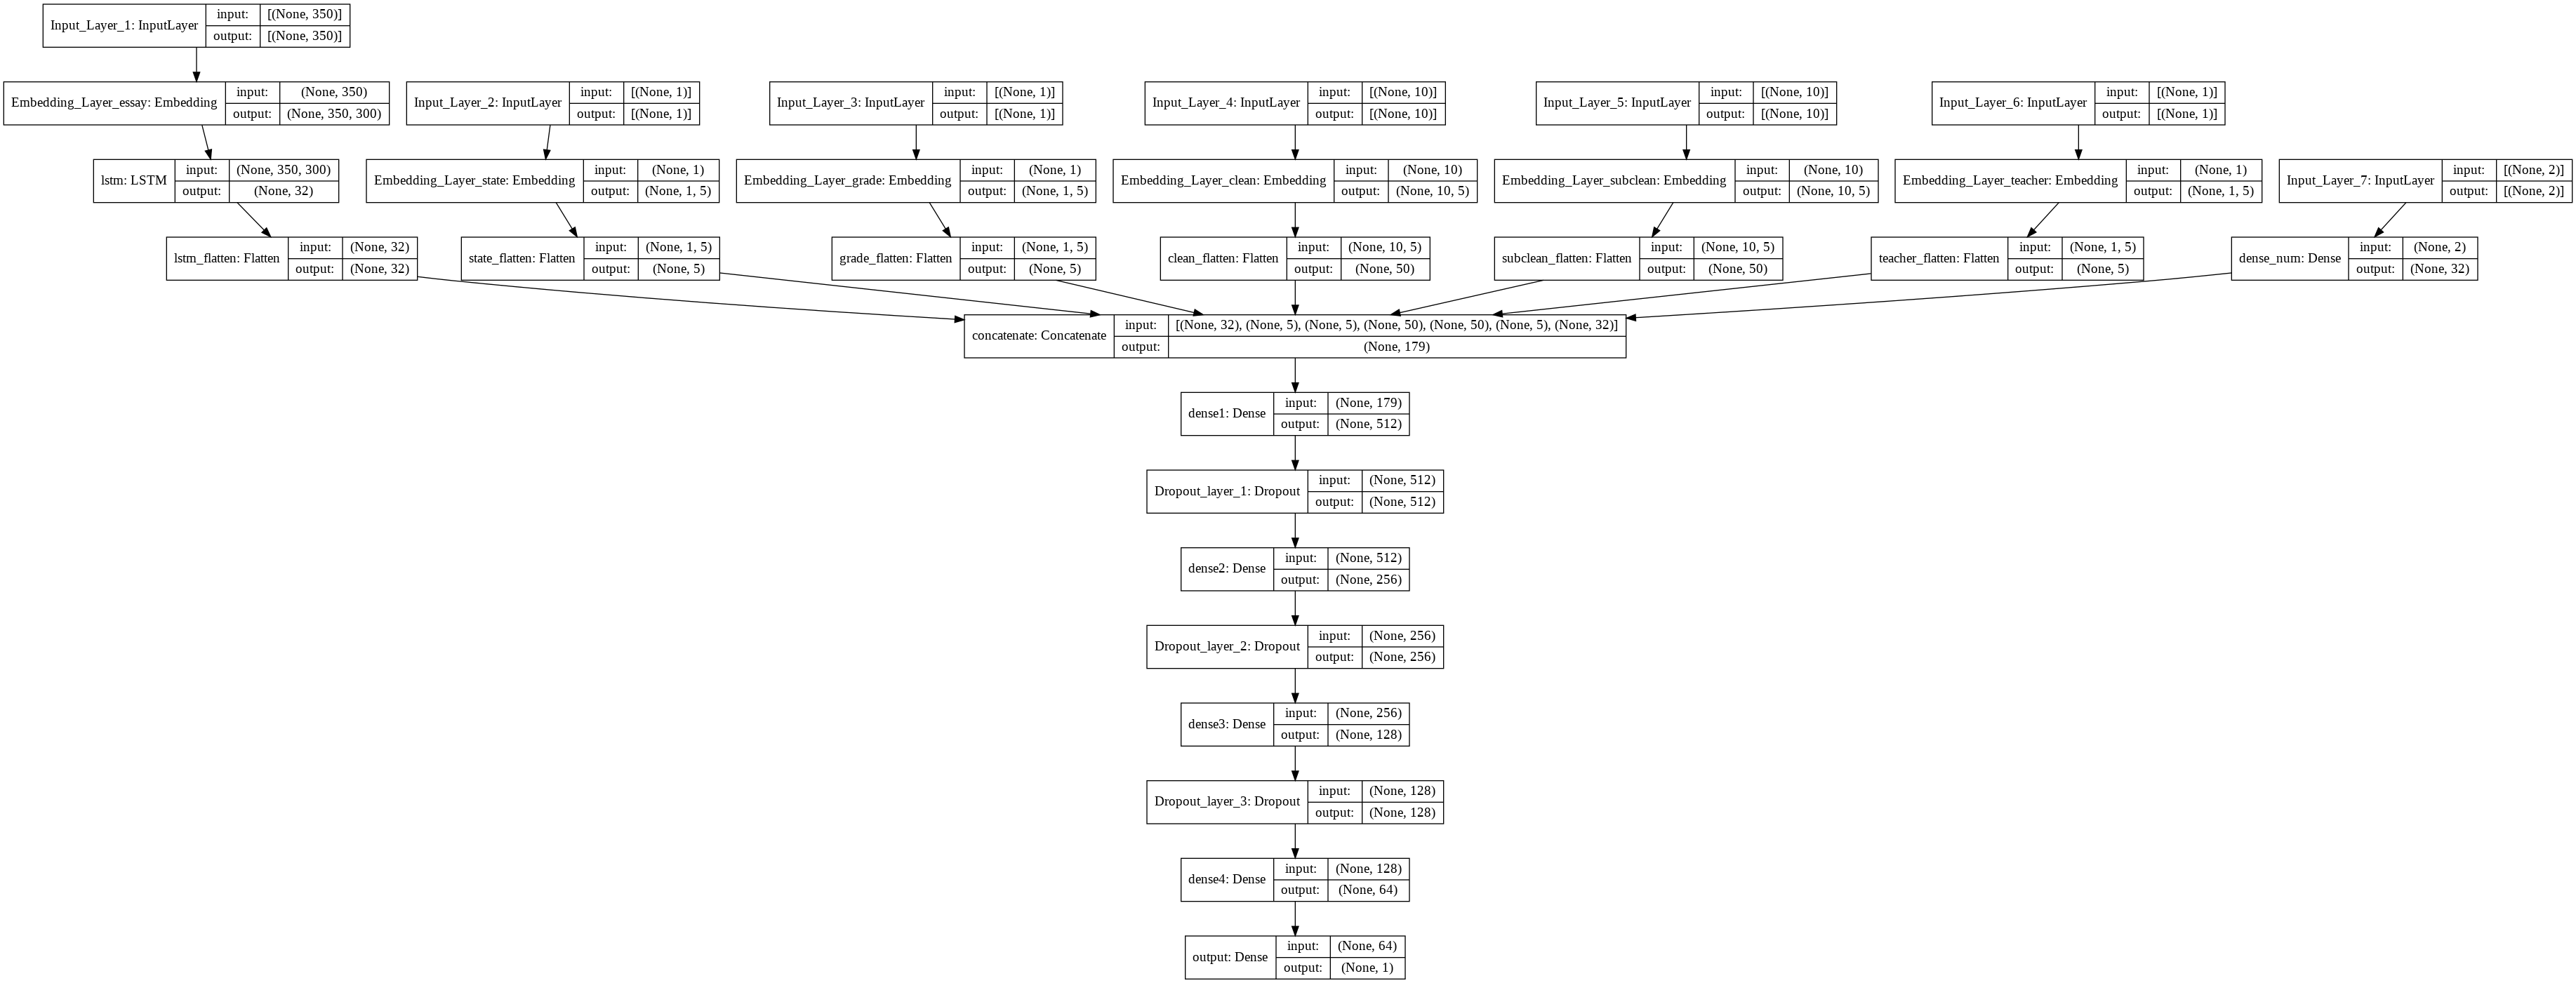

In [ ]:
tf.keras.utils.plot_model(model1, show_shapes = True, to_file = "model1.png")

In [ ]:

 
if not os.path.isdir('logs'):
    os.mkdir('logs')


In [ ]:
tb_callback = TensorBoard(log_dir='/content/logs',histogram_freq=1)
earlystop = EarlyStopping(monitor = 'val_aucroc',verbose=1,patience = 2)

In [ ]:
opt = Adam(0.001)

In [ ]:
model1.compile(optimizer=opt,loss='binary_crossentropy',metrics=[aucroc])

#fit data

In [ ]:
hist = model1.fit([padded_train,encoded_train_state,encoded_train_grade,padded_train_clean,padded_train_subclean,encoded_train_teacher,num_data_train.values],
                  x_test.values,
                  validation_data = ([padded_cv,encoded_cv_state,encoded_cv_grade,padded_cv_clean,padded_cv_subclean,encoded_cv_teacher,num_data_cv],
                                     cv_test.values),
                  epochs = 5,
                  batch_size = 64,
                  validation_batch_size = 512,
                  callbacks = [tb_callback])

Epoch 1/5
1025/1025 [==============================] - 64s 62ms/step - loss: 0.4233 - aucroc: 0.5233 - val_loss: 0.4239 - val_aucroc: 0.5421
Epoch 2/5
1025/1025 [==============================] - 63s 61ms/step - loss: 0.4231 - aucroc: 0.5228 - val_loss: 0.4212 - val_aucroc: 0.5732
Epoch 3/5
1025/1025 [==============================] - 54s 53ms/step - loss: 0.4228 - aucroc: 0.5234 - val_loss: 0.4225 - val_aucroc: 0.5475
Epoch 4/5
1025/1025 [==============================] - 51s 50ms/step - loss: 0.4230 - aucroc: 0.5305 - val_loss: 0.4217 - val_aucroc: 0.5535
Epoch 5/5
1025/1025 [==============================] - 53s 51ms/step - loss: 0.4238 - aucroc: 0.5299 - val_loss: 0.4236 - val_aucroc: 0.5544


In [ ]:
cv_test.value_counts()

1    18541
0     3309
Name: project_is_approved, dtype: int64

In [ ]:
x_test.value_counts()

1    55623
0     9925
Name: project_is_approved, dtype: int64

In [ ]:
# tensor = tf.constant([[1,2.4,3],[4,5,6],[7,8,9]])


In [ ]:
# tensor.numpy()

array([[1. , 2.4, 3. ],
       [4. , 5. , 6. ],
       [7. , 8. , 9. ]], dtype=float32)

In [ ]:
param = hist.history

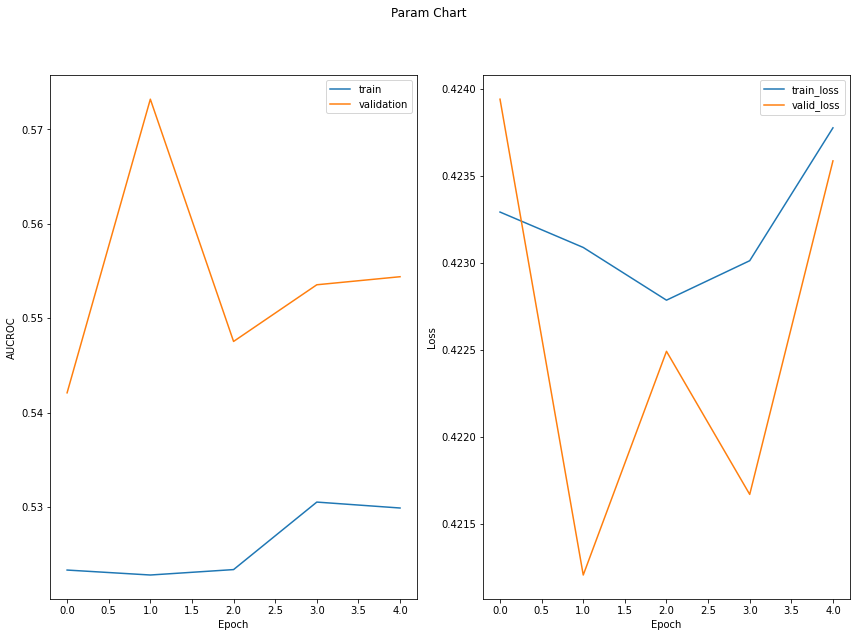

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.plot(param['aucroc'],label = 'train')
plt.plot(param['val_aucroc'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('AUCROC')
plt.legend()

plt.subplot(122)
plt.plot(param['loss'],label='train_loss')
plt.plot(param['val_loss'],label='valid_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.suptitle('Param Chart',y = 1.1)

plt.show()

In [1]:
# %tensorboard --logdir /content/logs

#MODEL - 2

In [ ]:
vect = TfidfVectorizer()

In [ ]:
vect.fit_transform(x_train['essay'])

<65548x46223 sparse matrix of type '<class 'numpy.float64'>'
	with 7079902 stored elements in Compressed Sparse Row format>

In [ ]:
word_idf  = dict(zip(vect.get_feature_names(),vect.idf_))

In [ ]:
# word_idf

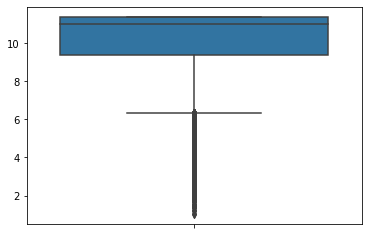

In [ ]:
sns.boxplot(y=vect.idf_)

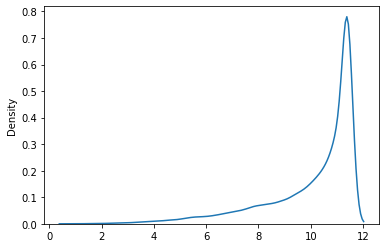

In [ ]:
sns.kdeplot(vect.idf_)

In [ ]:
p_25 = np.percentile(sorted(vect.idf_),25)

In [ ]:
p_75 = np.percentile(sorted(vect.idf_),75)

In [ ]:
iqr = p_75 - p_25

In [ ]:
u_whisker = np.percentile(sorted(vect.idf_),75) + 1.5*iqr

In [ ]:
l_whisker = np.percentile(sorted(vect.idf_),25) - 1.5*iqr

In [ ]:
fin_dict = {k:v for k,v in word_idf.items() if v > l_whisker and v < u_whisker }

In [ ]:
len(fin_dict),len(word_idf)

(43587, 46223)

##Excluding the high/v.low IDF words

In [ ]:
def preprocess(text):
    x = text.split() 
    # print(x)
    fin_x = [y for y in x if y.lower()  in fin_dict.keys()]
    # print(fin_x)
    return ' '.join(fin_x)

In [ ]:
t = 'I have a baby , and what do you want 1942 arizona'

In [ ]:
f = preprocess(t)

In [ ]:
x_train['tf_text'] = x_train['essay'].apply(preprocess)
cv_train['tf_text'] = cv_train['essay'].apply(preprocess)
y_train['tf_text'] = y_train['essay'].apply(preprocess)

In [ ]:
x_train['tf_text'][0]

'fairy tale lakeshore pacing tall tales paul bunyan johnny appleseed sink vs float'

In [ ]:
word_idf['tall']

6.886546546468554

In [ ]:
tok = Tokenizer()

In [ ]:
tok.fit_on_texts(x_train['tf_text'])

In [ ]:
tf_index = tok.word_index

In [ ]:
encoded_train_tf = np.array(tok.texts_to_sequences(x_train['tf_text']))
encoded_cv_tf = np.array(tok.texts_to_sequences(cv_train['tf_text']))
encoded_test_tf = np.array(tok.texts_to_sequences(y_train['tf_text']))

In [ ]:
padded_train_tf = pad_sequences(encoded_train_tf, maxlen= 350,padding='post',truncating='post')

In [ ]:
padded_cv_tf = pad_sequences(encoded_cv_tf, maxlen= 350,padding='post',truncating='post')
padded_test_tf = pad_sequences(encoded_test_tf, maxlen= 350,padding='post',truncating='post')


In [ ]:
# with open('/content/drive/MyDrive/Datasets/glove_vectors','rb') as g:
#     glove = pickle.load(g)
#     words_glove = set(glove.keys())

In [ ]:
embedding_matrix_tf = np.zeros((len(tf_index) + 1, 300))
for word, i in tqdm(tf_index.items()):
    embedding_vector_tf = glove.get(word)
    if embedding_vector_tf is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix_tf[i] = embedding_vector_tf

100%|██████████| 43587/43587 [00:00<00:00, 382122.06it/s]


#Input_layer_TF

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
input_layer_8 = Input(shape = (350, ), name = "Input_Layer_8")

embed_layer_essay_tf = Embedding(input_dim = len(tf_index) + 1, output_dim = 300, weights = [embedding_matrix_tf], 
                        input_length = 350, trainable = False, 
                        name = "Embedding_Layer_essay_tf")(input_layer_8)

lstm_layer_tf = LSTM(32)(embed_layer_essay_tf)

flatten_8 = Flatten(name='lstm_flatten')(lstm_layer_tf)

In [ ]:
if not os.path.isdir('logs2'):
    os.mkdir('logs2')

In [ ]:
tb_callback = TensorBoard(log_dir='/content/logs2',histogram_freq=1)

In [ ]:
hist2 = model1.fit([padded_train_tf,encoded_train_state,encoded_train_grade,padded_train_clean,padded_train_subclean,encoded_train_teacher,num_data_train.values],
                  x_test.values,
                  validation_data = ([padded_cv_tf,encoded_cv_state,encoded_cv_grade,padded_cv_clean,padded_cv_subclean,encoded_cv_teacher,num_data_cv],
                                     cv_test.values),
                  epochs = 5,
                  batch_size = 64,
                  validation_batch_size = 512,
                   callbacks = [tb_callback])

Epoch 1/5
1025/1025 [==============================] - 64s 62ms/step - loss: 0.4228 - aucroc: 0.5371 - val_loss: 0.4214 - val_aucroc: 0.5427
Epoch 2/5
1025/1025 [==============================] - 54s 52ms/step - loss: 0.4224 - aucroc: 0.5390 - val_loss: 0.4221 - val_aucroc: 0.5426
Epoch 3/5
1025/1025 [==============================] - 53s 51ms/step - loss: 0.4230 - aucroc: 0.5389 - val_loss: 0.4216 - val_aucroc: 0.5469
Epoch 4/5
1025/1025 [==============================] - 51s 50ms/step - loss: 0.4237 - aucroc: 0.5337 - val_loss: 0.4317 - val_aucroc: 0.5047
Epoch 5/5
1025/1025 [==============================] - 53s 52ms/step - loss: 0.4260 - aucroc: 0.5302 - val_loss: 0.4274 - val_aucroc: 0.5294


In [2]:
# %tensorboard --logdir /content/logs2

As the data is imbalanced, when splitting the validation dataset into batches, few batches have only positive/negative y values. This throws an error for division by 0 when calculating AUC value

In [ ]:
param = hist2.history

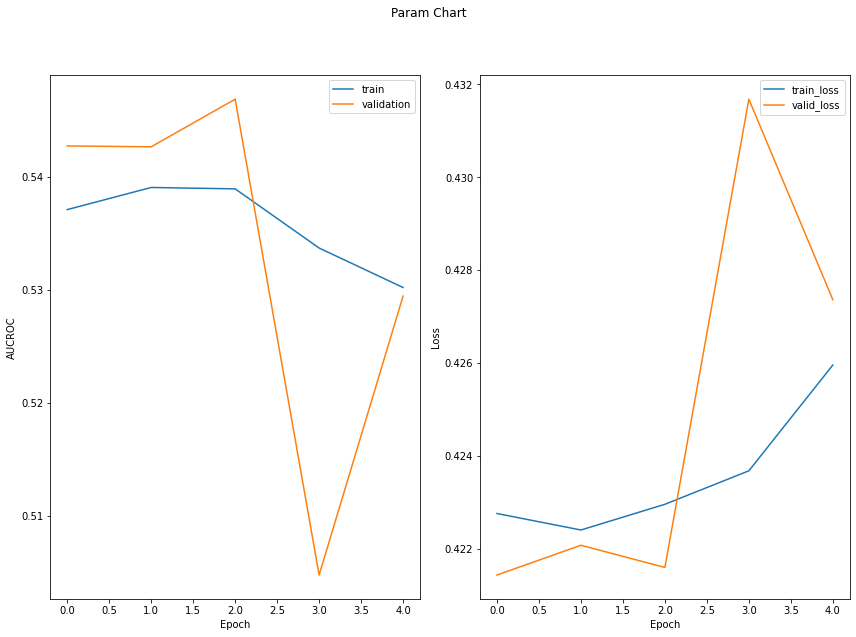

In [ ]:
plt.figure(figsize=(12,8))
plt.subplot(121)
plt.plot(param['aucroc'],label = 'train')
plt.plot(param['val_aucroc'],label='validation')
plt.xlabel('Epoch')
plt.ylabel('AUCROC')
plt.legend()

plt.subplot(122)
plt.plot(param['loss'],label='train_loss')
plt.plot(param['val_loss'],label='valid_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.suptitle('Param Chart',y = 1.1)

plt.show()

#MODEL 3

In [ ]:
ohe_train = pd.get_dummies(data = x_train,columns=['school_state','teacher_prefix','project_grade_category','clean_categories','clean_subcategories'],drop_first=True)
ohe_cv = pd.get_dummies(data = cv_train,columns=['school_state','teacher_prefix','project_grade_category','clean_categories','clean_subcategories'],drop_first=True)
ohe_test = pd.get_dummies(data = y_train,columns=['school_state','teacher_prefix','project_grade_category','clean_categories','clean_subcategories'],drop_first=True)

In [ ]:
ohe_train.drop(['project_is_approved','essay','tf_text'],axis=1,inplace=True)
ohe_cv.drop(['project_is_approved','essay','tf_text'],axis=1,inplace=True)
ohe_test.drop(['project_is_approved','essay','tf_text'],axis=1,inplace=True)


In [ ]:
ohe_train.shape

(65548, 497)

In [ ]:
ohe_cv = pad_sequences(ohe_cv.values, maxlen= 497,padding='post',truncating='post')
ohe_test = pad_sequences(ohe_test.values, maxlen= 497,padding='post',truncating='post')

In [ ]:
# ohe_cv[:5]

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
input_layer_1 = Input(shape = (350, ), name = "Input_Layer_1")

embed_layer_essay = Embedding(input_dim = len(word_index) + 1, output_dim = 300, weights = [embedding_matrix], 
                        input_length = 350, trainable = False, 
                        name = "Embedding_Layer_essay")(input_layer_1)

lstm_layer = LSTM(32)(embed_layer_essay)

flatten_1 = Flatten(name='lstm_flatten')(lstm_layer)

print(flatten_1.shape)

(None, 32)


In [ ]:
ohe_train.shape

TensorShape([65548, 497, 1])

In [ ]:
ohe_train = tf.expand_dims(ohe_train,axis=2)
ohe_cv = tf.expand_dims(ohe_cv,axis=2)
ohe_test = tf.expand_dims(ohe_test,axis=2)


In [ ]:
input_10 = Input((497,1),name='OHE_input')
conv_1 = Conv1D(filters=512, kernel_size = 1, padding = "valid", activation = "relu",
                kernel_initializer = tf.keras.initializers.HeUniform(),
                name = "Convolution_layer_1")(input_10)

conv_2 = Conv1D(filters=256, kernel_size = 1,strides=2, padding = "valid", activation = "relu",
                kernel_initializer = tf.keras.initializers.HeUniform(),
                name = "Convolution_layer_2")(conv_1)

conv_3 = Conv1D(filters=128, kernel_size = 1, padding = "valid", activation = "relu",
                kernel_initializer = tf.keras.initializers.HeUniform(),
                name = "Convolution_layer_3")(conv_2)

flatten_ohe = Flatten(name='flatten_ohe')(conv_3)

print(flatten_ohe.shape)


(None, 31872)


In [ ]:
concat = Concatenate()([flatten_1,flatten_ohe])

print(concat.shape)

flatten = Flatten(name = "Flatten_layer")(concat)


dense_10 = Dense(128,activation='relu',kernel_initializer='he_normal',name='dense_10')(flatten)

drop_1 = Dropout(0.1, name = "Dropout_layer_1")(dense_10)

dense_11 = Dense(128,activation='relu',kernel_initializer='he_normal',name='dense_11')(drop_1)

dense_12 = Dense(64,activation='relu',kernel_initializer='he_normal',name='dense_12')(dense_11)

drop_2 = Dropout(0.2, name = "Dropout_layer_2")(dense_12)

dense_13 = Dense(64,activation='relu',kernel_initializer='he_normal',name='dense_13')(drop_2)

drop_3 = Dropout(0.1, name = "Dropout_layer_3")(dense_13)

dense_14 = Dense(32,activation='relu',kernel_initializer='he_normal',name='dense_14')(drop_3)

dense_15 = Dense(16,activation='relu',kernel_initializer='he_normal',name='dense_15')(dense_14)

output_ohe = Dense(1,activation='sigmoid',name='output_layer_ohe')(dense_15)


(None, 31904)


In [ ]:
model3 = Model(inputs=[input_layer_1,input_10],outputs = output_ohe )

In [ ]:
if not os.path.isdir('logs3'):
    os.mkdir('logs3')

In [ ]:
tb_callback = TensorBoard(log_dir='/content/logs3',histogram_freq=1)

In [ ]:
model3.compile(optimizer=opt,loss='binary_crossentropy',metrics=[aucroc])

In [ ]:
hist3 = model3.fit([padded_train,ohe_train],x_test.values,
                   validation_data=([padded_cv,ohe_cv],cv_test.values),
                   epochs = 5,
                   batch_size =64,
                   validation_batch_size = 512,
                   callbacks = [tb_callback])

Epoch 1/5
1025/1025 [==============================] - 143s 106ms/step - loss: 0.4354 - aucroc: 0.5297 - val_loss: 0.4355 - val_aucroc: 0.5409
Epoch 2/5
1025/1025 [==============================] - 110s 107ms/step - loss: 0.4264 - aucroc: 0.5522 - val_loss: 0.4234 - val_aucroc: 0.5591
Epoch 3/5
1025/1025 [==============================] - 110s 107ms/step - loss: 0.4211 - aucroc: 0.5801 - val_loss: 0.4213 - val_aucroc: 0.5663
Epoch 4/5
1025/1025 [==============================] - 110s 108ms/step - loss: 0.4206 - aucroc: 0.5869 - val_loss: 0.4232 - val_aucroc: 0.5631
Epoch 5/5
1025/1025 [==============================] - 110s 108ms/step - loss: 0.4197 - aucroc: 0.5887 - val_loss: 0.4228 - val_aucroc: 0.5628


In [3]:
# %tensorboard --logdir /content/logs3

As it can be seen from the Tensorboard, the loss for every epoch is reducing and the AUC metric is gradually increasing.

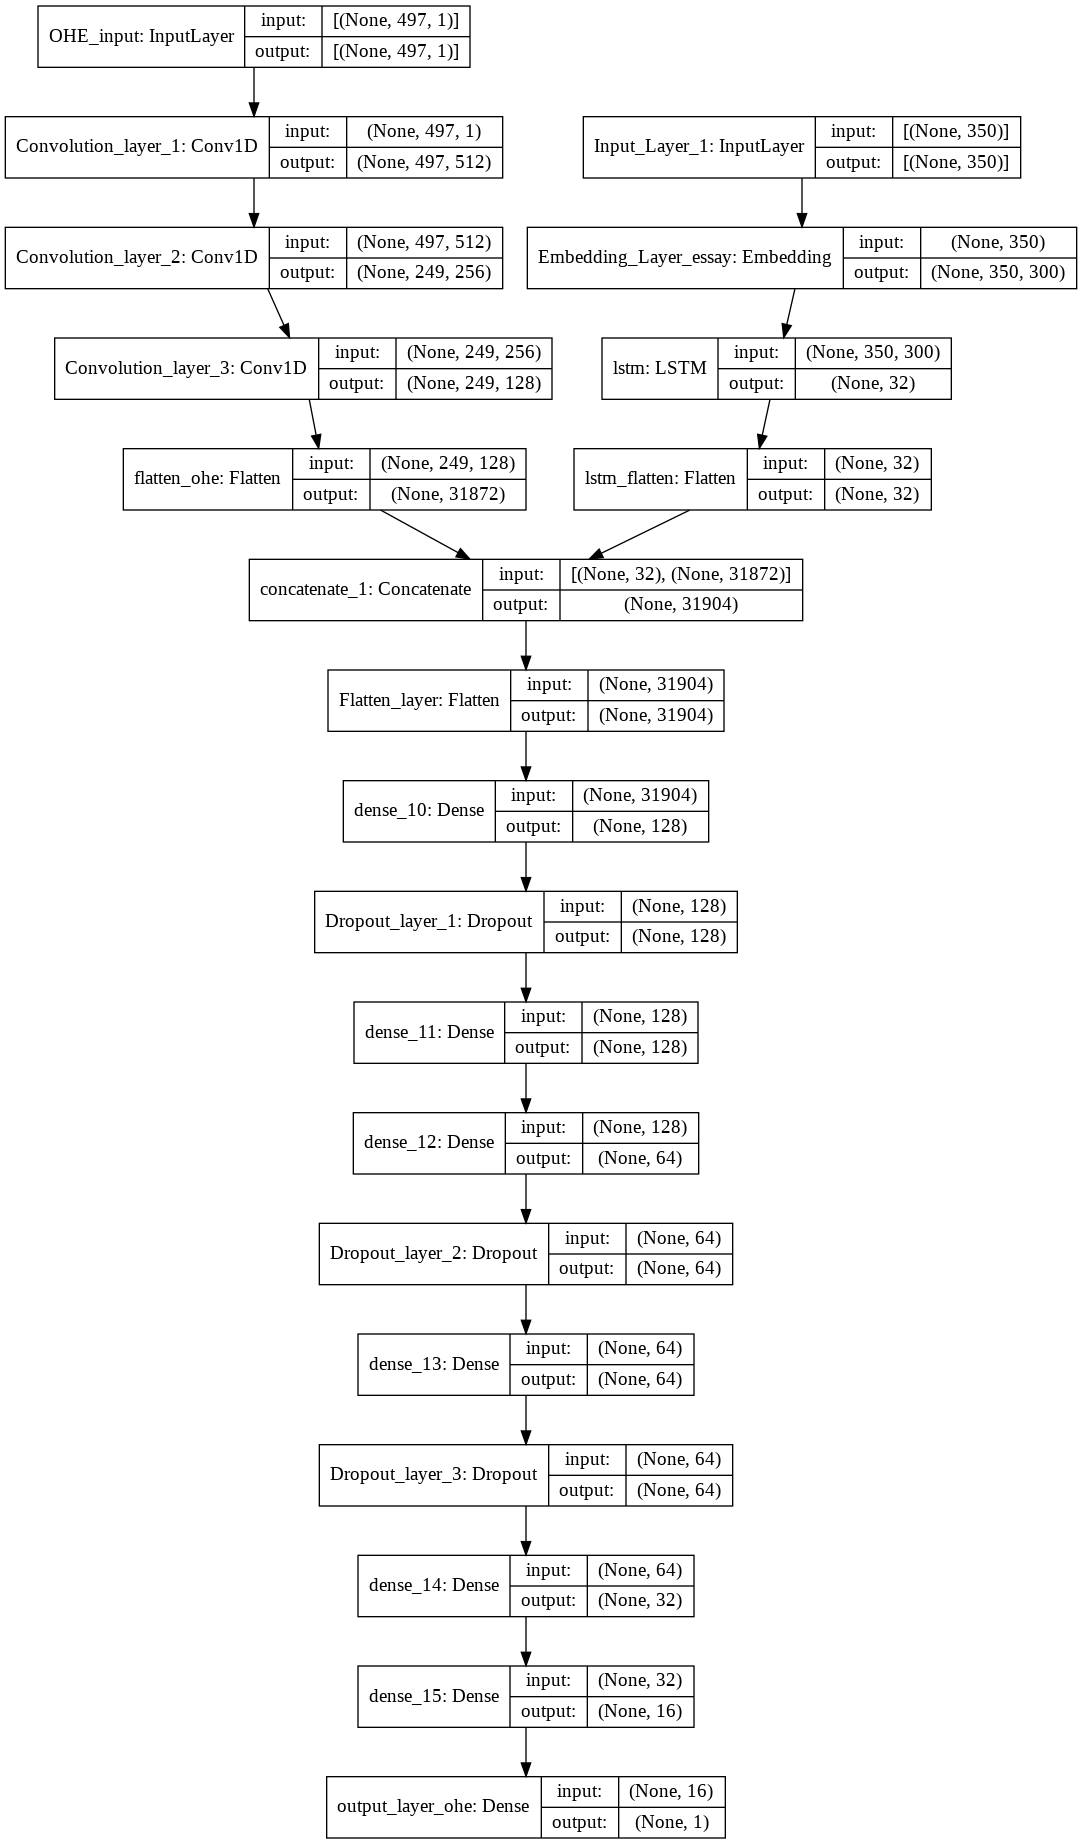

In [ ]:
tf.keras.utils.plot_model(model3, show_shapes = True, to_file = "model3.png")

#Observation

* The models are developed as mentioned in the task
* For the 2nd model, the outlier words whose IDF values falls outside the 25th and 75th percentile of boxplot are removed before preprocessing and training the model.
* Conv1D is being used for the 3rd model, where tf.expand_dims was used to match the input shape for the one hot encoded categorical variables
* The loss of all 3 models reduces as the number of epochs progress and the same can be visualized through tensorboard.
* Also, for some categorical variables when encoding, padding has been done to match the final size of the array.